<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Определение возраста покупателей по фото

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Значение MAE модели должно быть не больше 8.

## Исследовательский анализ данных

Импортируем необходимые библиотеки.

In [29]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

Сохраняем табличные данные в датафрейм.

In [30]:
df = pd.read_csv(
    '/datasets/faces/labels.csv'
)

Посмотрим на первые строки датафрейма.

In [31]:
df.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Определим размер датафрейма.

In [32]:
df.shape

(7591, 2)

В датасете 7591 фотографии. Предположим, что мы планируем предсказывать возраст с шагом 1 год в диапазоне от 1 до 100 лет. Тогда на людей одного возраста приходится в среднем 76 фотографий, что относительно мало. Для увеличения размера выборки используем аугументацию.

Рассмотрим статистические данные значений в столбце `real_age`.

In [33]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Посмотрим распределение значений в столбце `real_age`.

<AxesSubplot:>

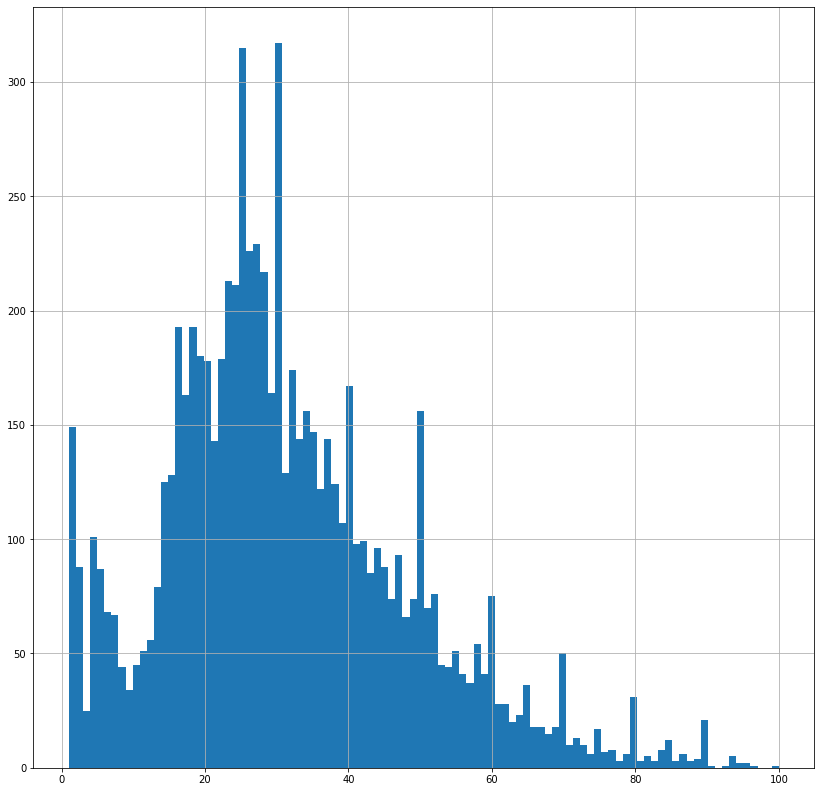

In [34]:
df['real_age'].hist(figsize=(14,14), bins=100)

Распределение данных в столбце с значениями возраста людей кажется логичным за исключением относительно большого количества фотографий детей в возрасте 1-2 года.

Из гистограммы видно, что на гистограмме присутствуют пики у значения 25 лет и значений, кратных 10, в диапазоне от 30 до 90 лет. Вероятно, для многих фотографий из этого диапазона возраст указан приблизительно. Учитывая эту особенность датасета, не стоит ожидать от обученной модели MAE выше ±5 лет.

Выведем несколько изображений из датасета.

In [35]:
datagen = ImageDataGenerator(rescale=1/255)

In [36]:
datagen_flow = datagen.flow_from_dataframe(
    dataframe=pd.read_csv('/datasets/faces/labels.csv'),
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='raw')

Found 7591 validated image filenames.


In [37]:
features, target = next(datagen_flow)

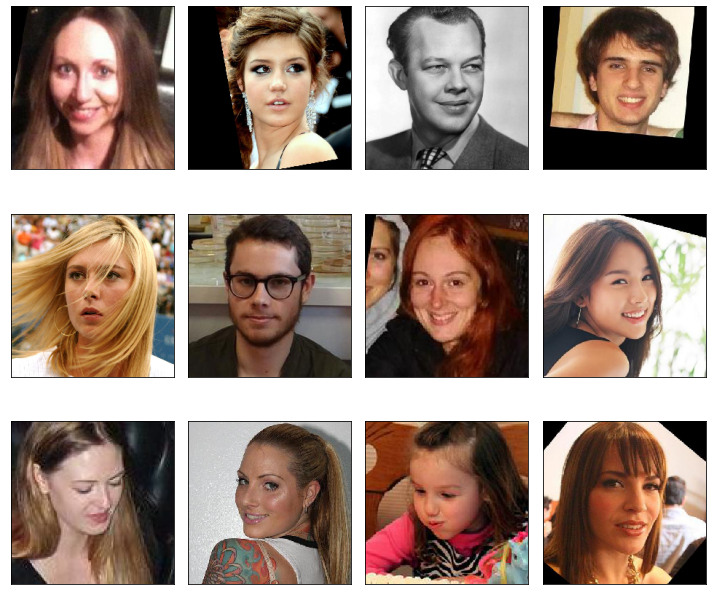

In [40]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**

Распределение данных в столбце с значениями возраста людей кажется логичным за исключением относительно большого количества фотографий детей в возрасте 1-2 года - эту особенность датасета лучше проверить вручную на наличие ошибок, которые могут повлиять на точность предсказаний.

Из гистограммы видно, что на гистограмме присутствуют пики у значения 25 лет и значений, кратных 10, в диапазоне от 30 до 90 лет. Вероятно, для многих фотографий из этого диапазона возраст указан приблизительно. Учитывая эту особенность датасета, не стоит ожидать от обученной модели MAE выше ±5 лет.

Датасет представляет собой цветные фотографии людей обоих полов разного возраста. Встречаются отсканированные черно-белые фотографии. Если голова человека в кадре наклонена относительно границ кадра, выполнен наклон исходного изображения, что видно по заполнению образовавшихся рамок.

## Обучение модели

Обучим нейронную сеть на обучающей выборке и проверим значение средней абсолютной ошибки на тестовой выборке.

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1/255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape, classes=1, include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation=None)) 
    optimizer = Adam(lr=0.00007)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

Train for 178 steps, validate for 60 steps

Epoch 1/10

178/178 - 97s - loss: 338.5426 - mae: 13.6284 - val_loss: 753.1857 - val_mae: 22.5116

Epoch 2/10

178/178 - 89s - loss: 134.2030 - mae: 8.8146 - val_loss: 668.2541 - val_mae: 20.8836

Epoch 3/10

178/178 - 89s - loss: 114.8659 - mae: 8.1315 - val_loss: 437.4502 - val_mae: 15.7952

Epoch 4/10

178/178 - 89s - loss: 100.2870 - mae: 7.6298 - val_loss: 174.1898 - val_mae: 10.0967

Epoch 5/10

178/178 - 90s - loss: 88.3949 - mae: 7.1105 - val_loss: 92.1379 - val_mae: 7.2942

Epoch 6/10

178/178 - 89s - loss: 82.5589 - mae: 6.8777 - val_loss: 119.7491 - val_mae: 8.1528

Epoch 7/10

178/178 - 89s - loss: 74.2086 - mae: 6.5815 - val_loss: 94.0002 - val_mae: 7.3941

Epoch 8/10

178/178 - 89s - loss: 68.2555 - mae: 6.3468 - val_loss: 127.1999 - val_mae: 8.5402

Epoch 9/10

178/178 - 89s - loss: 66.6661 - mae: 6.2647 - val_loss: 97.5500 - val_mae: 7.1314

Epoch 10/10

178/178 - 90s - loss: 60.4683 - mae: 5.9519 - val_loss: 99.5458 - val_mae: 7.5509

60/60 - 9s - loss: 99.5458 - mae: 7.5509

Test MAE: 7.5509

```

## Анализ обученной модели

Полученное значение MAE составило 7,6 года - обученная нами модель может быть использована для решения поставленных задач.

## Выводы

В предварительной части проекта выполнен исследовательский анализ данных.

Сделан вывод о том, что распределение данных в столбце с значениями возраста людей кажется логичным за исключением относительно большого количества фотографий детей в возрасте 1-2 года, и эту особенность датасета лучше проверить вручную на наличие ошибок, которые могут повлиять на точность предсказаний - в проекте проверка не выполнялась.

Из гистограммы видно, что на гистограмме присутствуют пики у значения 25 лет и значений, кратных 10, в диапазоне от 30 до 90 лет. Вероятно, для многих фотографий из этого диапазона возраст указан приблизительно. Учитывая эту особенность датасета, не стоит ожидать от обученной модели MAE выше ±5 лет.

Полученное значение MAE составило 7,6 года - обученная нами модель может быть использована для решения задач, поставленных супермаркетом. 

Как мы помним, модель необходима для решения 2-х задач:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Относительно 1-ой задачи. У нас нет информации о том, на какое количество групп планируется разделить диапазон возрастов посетителей. Нужно иметь в виду, что бОльшее количество групп приведет к бОльшим ошибкам при разбиении посетителей на группы. Учитывая среднюю абсолютную ошибку, предположу, что в делении более чем на 5 групп нет большого смысла.

Относительно 2-ой задачи. Предположим, что модель предполагается использовать в стране, в которой установлено ограничение на продажу определенной группы товаров людям, не достигшим 18-летнего возраста. Учитывая ошибку модели, для предсказанных значений возраста больше 10,4 лет относительно высока вероятность того, что модель ошибается, отсюда, порог срабатывания системы предупреждения о факте подозрительной продаже должен быть установлен на этом значении.